In [1]:
import numpy as np
import re
import sys
from PIL import Image
import cv2

def read_pfm(filename):
    file = open(filename, 'rb')
    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().decode('utf-8').rstrip()
    if header == 'PF':
        color = True
    elif header == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode('utf-8'))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().rstrip())
    if scale < 0:  # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>'  # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    file.close()
    return data, scale



# read an image
def read_img(filename):
    img = Image.open(filename)
    # scale 0~255 to 0~1
    np_img = np.array(img, dtype=np.float32) / 255.
    return np_img


# read a binary mask
def read_mask(filename):
    return read_img(filename) > 0.5


# save a binary mask
def save_mask(filename, mask):
    assert mask.dtype == np.bool
    mask = mask.astype(np.uint8) * 255
    Image.fromarray(mask).save(filename)


# read a pair file, [(ref_view1, [src_view1-1, ...]), (ref_view2, [src_view2-1, ...]), ...]
def read_pair_file(filename):
    data = []
    with open(filename) as f:
        num_viewpoint = int(f.readline())
        # 49 viewpoints
        for view_idx in range(num_viewpoint):
            ref_view = int(f.readline().rstrip())
            src_views = [int(x) for x in f.readline().rstrip().split()[1::2]]
            if len(src_views) > 0:
                data.append((ref_view, src_views))
    return data

# torch.no_grad warpper for functions
def make_nograd_func(func):
    def wrapper(*f_args, **f_kwargs):
        with torch.no_grad():
            ret = func(*f_args, **f_kwargs)
        return ret

    return wrapper


# convert a function into recursive style to handle nested dict/list/tuple variables
def make_recursive_func(func):
    def wrapper(vars):
        if isinstance(vars, list):
            return [wrapper(x) for x in vars]
        elif isinstance(vars, tuple):
            return tuple([wrapper(x) for x in vars])
        elif isinstance(vars, dict):
            return {k: wrapper(v) for k, v in vars.items()}
        else:
            return func(vars)

    return wrapper

# a wrapper to compute metrics for each image individually
def compute_metrics_for_each_image(metric_func):
    def wrapper(depth_est, depth_gt, mask, *args):
        batch_size = depth_gt.shape[0]
        results = []
        # compute result one by one
        for idx in range(batch_size):
            ret = metric_func(depth_est[idx], depth_gt[idx], mask[idx], *args)
            results.append(ret)
        return torch.stack(results).mean()

    return wrapper


@make_nograd_func
@compute_metrics_for_each_image
def Thres_metrics(depth_est, depth_gt, mask, thres):
    assert isinstance(thres, (int, float))
    depth_est, depth_gt = depth_est[mask], depth_gt[mask]
    errors = torch.abs(depth_est - depth_gt)
    err_mask = errors > thres
    return torch.mean(err_mask.float())


# NOTE: please do not use this to build up training loss
@make_nograd_func
@compute_metrics_for_each_image
def AbsDepthError_metrics(depth_est, depth_gt, mask, thres=None):
    depth_est, depth_gt = depth_est[mask], depth_gt[mask]
    error = (depth_est - depth_gt).abs()
    if thres is not None:
        error = error[(error >= float(thres[0])) & (error <= float(thres[1]))]
        if error.shape[0] == 0:
            return torch.tensor(0, device=error.device, dtype=error.dtype)
    return torch.mean(error)

In [45]:
GT_DEPTHS_DIR = "/Users/umairkhawaja/Desktop/workspace/TUM/W23/AD4CV/Depths"
PRED_DEPTHS_DIR = "casmvsnet_outputs/"

In [46]:
from glob import glob
import os
from os.path import join

In [47]:
# import os
# import matplotlib.pyplot as plt
# from datasets.data_io import read_pfm  # Ensure this import path is correct for read_pfm function

# def plot_depth_maps_from_pfm(directory):
#     # List all files in the given directory
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             # Check for .pfm extension
#             if file.endswith('.pfm'):
#                 file_path = os.path.join(root, file)
#                 # Read the depth map from .pfm file
#                 depth_map, _ = read_pfm(file_path)

#                 # Plotting the depth map
#                 fig = plt.figure(figsize=(10, 5))
#                 plt.imshow(depth_map, cmap='plasma')  # 'plasma' colormap is good for depth maps
#                 plt.colorbar()
#                 plt.title(f'Depth Map: {root}/{file}')
#                 fig.savefig(file_path.replace(".pfm", ".jpg"))
#                 plt.show()
#                 plt.close('all')

In [48]:
def mean_relative_absolute_error(y_true, y_pred):
    """
    Compute the mean relative absolute error (MRAE) between two numpy arrays.

    Parameters:
    y_true (numpy.array): The ground truth values.
    y_pred (numpy.array): The predicted values.

    Returns:
    float: The MRAE metric result.
    """
    # Avoid division by zero
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    
    # Calculate MRAE
    mrae = np.mean(np.abs((y_true - y_pred) / y_true))
    
    return mrae

In [50]:
import os
from glob import glob
from os.path import join
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Assuming PRED_DEPTHS_DIR and GT_DEPTHS_DIR are defined, 
# along with read_pfm and read_mask functions

all_maes = []
for scene_dir in glob(PRED_DEPTHS_DIR + "/*"):
    if not scene_dir.endswith(".ply"):
        scene_name = scene_dir.split("/")[-1]
        scene_dmap_dir = join(scene_dir, "depth_est")
        scene_mask_dir = join(scene_dir, "mask")

        scene_metrics = []
        for pred_dmap_path in glob(scene_dmap_dir + "/*"):
            try:
                filename = pred_dmap_path.split("/")[-1]
                pred_mask_path = join(scene_mask_dir, filename.replace(".pfm", "_final.png"))
                
                pfm_num = int(filename.split(".")[0])
                zero_pad = "000" if pfm_num < 10 else "00"
                
                gt_dmap_path = join(GT_DEPTHS_DIR, scene_name, f"depth_map_{zero_pad}{pfm_num}.pfm")
                gt_mask_path = join(GT_DEPTHS_DIR, scene_name, f"depth_visual_{zero_pad}{pfm_num}.png")

                pred_dmap, pred_scale = read_pfm(pred_dmap_path)
                gt_dmap, gt_scale = read_pfm(gt_dmap_path)
                gt_mask = read_mask(gt_mask_path)
                pred_mask = read_mask(pred_mask_path)

                gt_dmap = gt_dmap * gt_mask
                pred_dmap = pred_dmap * pred_mask

                pred_dmap = pred_dmap.astype(np.float32)
                pred_dmap = cv2.resize(pred_dmap, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

                # Create a figure and a set of subplots
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

                # Display Ground truth depth map
                im1 = ax1.imshow(gt_dmap, cmap='plasma')
                ax1.set_title('Ground Truth Depth Map')
                fig.colorbar(im1, ax=ax1)  # Add colorbar for reference

                # Display Predicted depth map
                im2 = ax2.imshow(pred_dmap, cmap='plasma')
                ax2.set_title('Predicted Depth Map')
                fig.colorbar(im2, ax=ax2)  # Add colorbar for reference


                pred_dmap_gt_mask = pred_dmap * gt_mask
                im3 = ax3.imshow(pred_dmap_gt_mask, cmap='plasma')
                ax3.set_title('Predicted Depth Map with GT Mask')
                fig.colorbar(im3, ax=ax3)  # Add colorbar for reference


                mae = np.mean(np.abs(pred_dmap_gt_mask - gt_dmap))
                mrae = mean_relative_absolute_error(gt_dmap, pred_dmap_gt_mask)
                print(mae, mrae)

                plt.suptitle(f"Error with GT Masking:  MAE {mae:.3f} | MRAE {mrae:.3f}")
                
                # Save the figure to a JPG file
                plot_dir = f"{PRED_DEPTHS_DIR}/plots/{scene_name}/"
                Path(plot_dir).mkdir(parents=True, exist_ok=True)
                fig.savefig(f"{plot_dir}/{filename.replace('.pfm', '.jpg')}")
                plt.close('all')
                scene_metrics.append(mae)
            except FileNotFoundError as e:
                print(f"[MISSING DATA] {e.filename}")
        scene_error = np.mean(scene_metrics)
        all_maes.append(scene_error)

47.154934 0.41264853
105.273895 0.82135123
339.69037 0.62715864
423.9494 0.7081904
477.91907 0.7318432
365.07812 0.6619889
460.35895 0.73600096
301.18176 0.594635
165.47763 0.68374074
211.06664 0.7640322
285.3069 0.59702724
529.51056 0.82039195
109.05373 0.8764851
407.5387 0.8135253
457.2093 0.6941346
436.5277 0.76849914
366.25815 0.77141637
118.24156 0.82446927
333.54407 0.62703127
412.57983 0.6544855
450.83264 0.7002551
393.26834 0.6759
173.89438 0.78011894
185.86935 0.5911302
232.14764 0.6163974
182.49808 0.67894244
251.42535 0.72340983
127.138275 0.61831343
364.14767 0.6384237
366.57578 0.64671236
150.68764 0.6739989
275.77472 0.68699986
216.56107 0.806662
200.37709 0.6084308
106.719315 0.61637694
126.49658 0.6472314
171.74734 0.5871568
332.65027 0.7163997
92.88644 0.5960912
235.08827 0.64961284
274.17255 0.73515725
105.146 0.60367495
116.07876 0.71880805
86.15583 0.74501145
65.64982 0.63730735
73.01055 0.6484019
79.52757 0.6541698
104.58439 0.6986442
61.95467 0.6745144
63.284378 0

/Users/umairkhawaja/.pyenv/versions/3.10.13/envs/volrecon/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/umairkhawaja/.pyenv/versions/3.10.13/envs/volrecon/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[MISSING DATA] casmvsnet_outputs/scan12/mask/00000017_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000001_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000015_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000029_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000028_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000014_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000000_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000038_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000004_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000010_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000011_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000005_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000039_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000013_final.png
[MISSING DATA] casmvsnet_outputs/scan12/mask/00000007_final.png
[MISSING DATA] casmvsnet_outputs/scan12/

/Users/umairkhawaja/.pyenv/versions/3.10.13/envs/volrecon/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/umairkhawaja/.pyenv/versions/3.10.13/envs/volrecon/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


249.21506 0.6228481
252.44154 0.5907634
308.41483 0.60523236
197.55887 0.60448
117.6892 0.71613663
145.28998 0.7581526
182.52737 0.59520066
333.32864 0.68278426
86.042076 0.85966015
319.12418 0.62244374
293.22296 0.69207406
96.55795 0.80372095
227.12384 0.62062734
280.60184 0.57045746
269.68417 0.54928964
267.01172 0.6487608
155.31784 0.77269197
153.27942 0.65440184
188.44034 0.6790516
159.24905 0.74655753
206.31393 0.6889563
114.990906 0.70163894
256.96002 0.57882434
258.62955 0.5806551
133.3691 0.71980566
223.53294 0.7000733
193.43155 0.70769596
141.5542 0.6500857
85.1066 0.69613296
106.296715 0.7004293
131.71223 0.6478265
254.15073 0.6157922
81.863 0.6897707
173.04826 0.65760744
183.7163 0.67111987
100.10133 0.6941984
92.249664 0.77333057
81.63649 0.753098
70.08399 0.75035197
72.84953 0.7502179
63.28124 0.739808
73.64902 0.7616888
50.391033 0.7359148
63.93524 0.74811375
[MISSING DATA] casmvsnet_outputs/scan118/mask/00000048_final.png
[MISSING DATA] casmvsnet_outputs/scan118/mask/000

/Users/umairkhawaja/.pyenv/versions/3.10.13/envs/volrecon/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/umairkhawaja/.pyenv/versions/3.10.13/envs/volrecon/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[MISSING DATA] casmvsnet_outputs/scan32/mask/00000017_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000001_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000015_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000029_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000028_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000014_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000000_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000038_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000004_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000010_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000011_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000005_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000039_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000013_final.png
[MISSING DATA] casmvsnet_outputs/scan32/mask/00000007_final.png
[MISSING DATA] casmvsnet_outputs/scan32/

/Users/umairkhawaja/.pyenv/versions/3.10.13/envs/volrecon/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/umairkhawaja/.pyenv/versions/3.10.13/envs/volrecon/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [38]:
# np.mean(np.array(all_maes[:-1])) | MVSNET: 136mm

In [55]:
np.mean(np.array([e for e in all_maes if e > 0]))

163.89218

In [2]:
import numpy as np
import imageio

# Replace with the actual path to one of your COLMAP binary depth map files
binary_depth_map_path = '/home/dataset/DTU_TEST/scan24/dense/0/stereo/depth_maps/000000.png.geometric.bin'
output_image_path = './000000.png'

# Read the binary depth map file
with open(binary_depth_map_path, 'rb') as file:
    width, height, depth_scale = np.fromfile(file, dtype=np.float32, count=3)
    print(width, height, depth_scale)
    depth_map = np.fromfile(file, dtype=np.float32).reshape((height, width))

# Convert the depth map to an image (normalize and scale to 0-255)
depth_map_normalized = cv2.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Save the depth map as an image file
imageio.imwrite(output_image_path, depth_map_normalized)


4.3918557e-05 0.00016898345 6.146097e-16


TypeError: 'numpy.float32' object cannot be interpreted as an integer

In [3]:
#!/usr/bin/env python

# Copyright (c) 2023, ETH Zurich and UNC Chapel Hill.
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#
#     * Redistributions in binary form must reproduce the above copyright
#       notice, this list of conditions and the following disclaimer in the
#       documentation and/or other materials provided with the distribution.
#
#     * Neither the name of ETH Zurich and UNC Chapel Hill nor the names of
#       its contributors may be used to endorse or promote products derived
#       from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDERS OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.


import argparse
import numpy as np
import os
import struct


def read_array(path):
    with open(path, "rb") as fid:
        width, height, channels = np.genfromtxt(
            fid, delimiter="&", max_rows=1, usecols=(0, 1, 2), dtype=int
        )
        fid.seek(0)
        num_delimiter = 0
        byte = fid.read(1)
        while True:
            if byte == b"&":
                num_delimiter += 1
                if num_delimiter >= 3:
                    break
            byte = fid.read(1)
        array = np.fromfile(fid, np.float32)
    array = array.reshape((width, height, channels), order="F")
    return np.transpose(array, (1, 0, 2)).squeeze()


def write_array(array, path):
    """
    see: src/mvs/mat.h
        void Mat<T>::Write(const std::string& path)
    """
    assert array.dtype == np.float32
    if len(array.shape) == 2:
        height, width = array.shape
        channels = 1
    elif len(array.shape) == 3:
        height, width, channels = array.shape
    else:
        assert False

    with open(path, "w") as fid:
        fid.write(str(width) + "&" + str(height) + "&" + str(channels) + "&")

    with open(path, "ab") as fid:
        if len(array.shape) == 2:
            array_trans = np.transpose(array, (1, 0))
        elif len(array.shape) == 3:
            array_trans = np.transpose(array, (1, 0, 2))
        else:
            assert False
        data_1d = array_trans.reshape(-1, order="F")
        data_list = data_1d.tolist()
        endian_character = "<"
        format_char_sequence = "".join(["f"] * len(data_list))
        byte_data = struct.pack(
            endian_character + format_char_sequence, *data_list
        )
        fid.write(byte_data)


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "-d", "--depth_map", help="path to depth map", type=str, required=True
    )
    parser.add_argument(
        "-n", "--normal_map", help="path to normal map", type=str, required=True
    )
    parser.add_argument(
        "--min_depth_percentile",
        help="minimum visualization depth percentile",
        type=float,
        default=5,
    )
    parser.add_argument(
        "--max_depth_percentile",
        help="maximum visualization depth percentile",
        type=float,
        default=95,
    )
    args = parser.parse_args()
    return args


def main():
    args = parse_args()

    if args.min_depth_percentile > args.max_depth_percentile:
        raise ValueError(
            "min_depth_percentile should be less than or equal "
            "to the max_depth_perceintile."
        )

    # Read depth and normal maps corresponding to the same image.
    if not os.path.exists(args.depth_map):
        raise FileNotFoundError("File not found: {}".format(args.depth_map))

    if not os.path.exists(args.normal_map):
        raise FileNotFoundError("File not found: {}".format(args.normal_map))


    normal_map = read_array(args.normal_map)

    



    # Visualize the normal map.
    plt.figure()
    plt.imshow(normal_map)
    plt.title("normal map")

    plt.show()


## COLMAP

Text(0.5, 1.0, 'depth map')

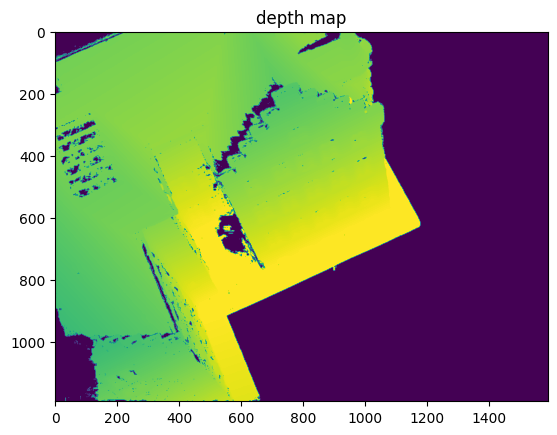

In [5]:
depth_map = read_array(binary_depth_map_path)
min_depth_percentile = 5
max_depth_percentile = 95
min_depth, max_depth = np.percentile(
        depth_map, [min_depth_percentile, max_depth_percentile]
    )
depth_map[depth_map < min_depth] = min_depth
depth_map[depth_map > max_depth] = max_depth

import pylab as plt

# Visualize the depth map.
plt.figure()
plt.imshow(depth_map)
plt.title("depth map")